In [1]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlGDConfig,
    ControlEMVPConfig,
    ProposedMethodConfig,
    ProposedModifiedEMVPConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
from simple_ls_optimizer import SimpleLSOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator
from cv_embedding_estimation import CrossValidationEmbeddingEstimator, estimate_embedding_cv
from itertools import product
import seaborn as sns
from matplotlib.colors import LogNorm
import rdatasets


## Loading the dataset

In [2]:
DATASETS = set(["lynx", "ozone"])

In [48]:
DATASET = "ozone"

assert DATASET in DATASETS, f"Dataset {DATASET} not recognized. Available datasets: {DATASETS}"

In [49]:
# dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
match DATASET:
    case "lynx":
        dataset = rdatasets.data("lynx").drop(columns=["rownames"])
        dataset.set_index('time', inplace=True)
    case "ozone":
        dataset = pd.read_csv("./data/Arosa_Ozone_Thickness_Dataset.csv")
        dataset["year"] = 1925 + dataset["year"]
        dataset["time"] = pd.to_datetime(dataset[["year", "month"]].assign(day=1))
        dataset.set_index("time", inplace=True)
        dataset = dataset.rename(columns={
            "thick": "value"
        }).drop(columns=["year", "month"])
dataset.head()

,value
time,
1926-07-01,312
1926-08-01,300
1926-09-01,281
1926-10-01,267
1926-11-01,295


In [50]:
dataset.describe()

,value
count,518.000000
mean,336.637066
std,38.221784
min,266.000000
25%,305.000000
50%,335.000000
75%,365.000000
max,430.000000


In [51]:
# time_series = dataset['Value'].values
time_series = dataset['value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [52]:
# time_series_mu = np.mean(time_series)
# time_series_std = np.std(time_series)

# time_series = np.diff(time_series, prepend=time_series[0])
# time_series = (time_series - time_series_mu) / time_series_std
match DATASET:
    case "lynx":
        time_series = np.log10(time_series)
    case "ozone":
        time_series = np.log10(time_series - 260)

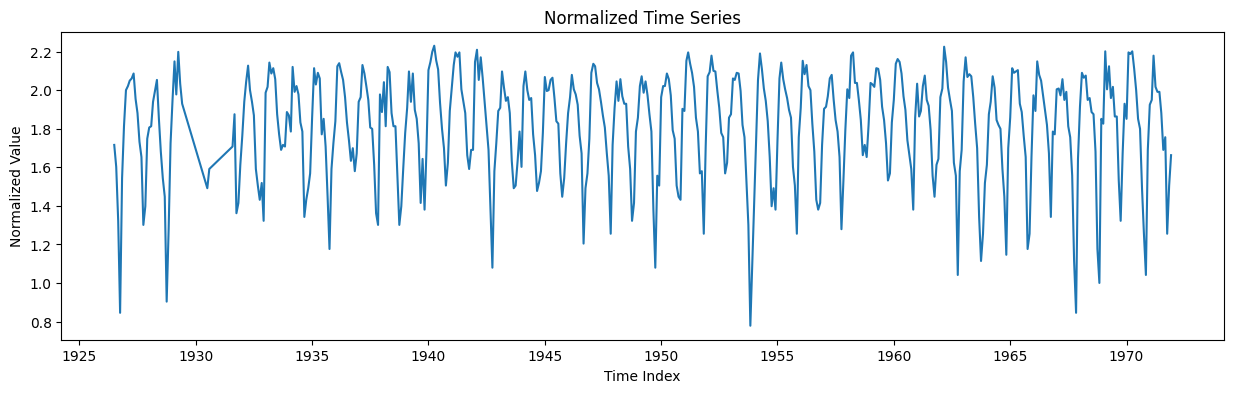

In [53]:
plt.figure(figsize=(15, 4))
plt.plot(dataset.index, time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [54]:
ami_tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {ami_tau}")

Estimated tau: 4


In [55]:
cao_dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=ami_tau,
        max_dim=10,
        optimum_selection_method=OptimalDimensionSelectionMethod.E1_E2_COMBINED,
        plot=False,
    ),
)
print(f"Estimated dimension: {cao_dim}")

Estimated dimension: 7


## Testing Cross-Validation Embedding Estimation

Let's compare the traditional AMI + Cao's method with the new modified multifold cross-validation criterion for embedding parameter estimation.

In [56]:
# Compare traditional AMI + Cao estimation with CV-based estimation
print("=== Traditional Methods (AMI + Cao) ===")
print(f"AMI estimated tau: {ami_tau}")
print(f"Cao estimated dimension: {cao_dim}")

# Use CV-based estimation with a smaller parameter space for faster computation
print("\n=== Cross-Validation Based Estimation ===")
cv_estimator = CrossValidationEmbeddingEstimator(
    tau_range=(1, 5),      # Smaller range for demonstration
    dim_range=(2, 6),      # Smaller range for demonstration  
    n_splits=3,            # Fewer splits for faster computation
    scoring_metric="mse",  # Mean squared error
    verbose=False
)

tau_cv, dim_cv = cv_estimator.estimate(time_series)
print(f"CV estimated tau: {tau_cv}")
print(f"CV estimated dimension: {dim_cv}")

=== Traditional Methods (AMI + Cao) ===
AMI estimated tau: 4
Cao estimated dimension: 7

=== Cross-Validation Based Estimation ===
CV estimated tau: 1
CV estimated dimension: 2


In [57]:
# You can also try different scoring metrics
print("\n=== CV with different scoring metrics ===")

metrics = ["mse", "mae", "r2"]
cv_results = {}

for metric in metrics:
    estimator = CrossValidationEmbeddingEstimator(
        tau_range=(1, 4),
        dim_range=(2, 5),
        n_splits=3,
        scoring_metric=metric,
        verbose=False  # Set to True to see progress
    )
    tau_est, dim_est = estimator.estimate(time_series)
    cv_results[metric] = (tau_est, dim_est)
    print(f"{metric.upper()} metric: tau={tau_est}, dim={dim_est}")

print(f"\nComparison:")
print(f"Traditional (AMI+Cao): tau={ami_tau}, dim={cao_dim}")
for metric, (tau_est, dim_est) in cv_results.items():
    print(f"CV ({metric}): tau={tau_est}, dim={dim_est}")


=== CV with different scoring metrics ===
MSE metric: tau=1, dim=2
MAE metric: tau=1, dim=2
R2 metric: tau=1, dim=2

Comparison:
Traditional (AMI+Cao): tau=4, dim=7
CV (mse): tau=1, dim=2
CV (mae): tau=1, dim=2
CV (r2): tau=1, dim=2


## Configuring the models

In [58]:
tau, dim = tau_cv, dim_cv

In [202]:
proposed_configs = [
    # *[
    #     ProposedMethodConfig(
    #         approach="pretraining",
    #         optimizer=SvdOptimizer(epsilon=eps, alpha=alpha, beta=beta, delta=0),
    #         m=m,
    #         post_tune=post_tune,
    #         n=dim,
    #         embedding_tau=tau,
    #         # rho=rho,
    #         use_kmeans_centres=kmeans,
    #         use_local_sigma=local_sigma,
    #         tuning_val_split=tuning_val_split,
    #         ridge=ridge # for pre-training
    #     )
    #     for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 30]
    #     # for m in [10, 15, 100, 200, 300]
    #     # for m in [100]
    #     for alpha in [0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5]
    #     # for beta in [None, 1, 10, 100]
    #     for beta in [None]
    #     # for rho in [0.1, 0.2, 0.3, 0.5, 1]
    #     # for beta in [None]
    #     for eps in [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    #     # for ridge in [0.0, 1e-4, 1e-3, 1e-2]
    #     # for approach in ["pretraining", "no-pretraining"]
    #     for post_tune, tuning_val_split in filter(
    #         lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
    #         product([True, False], [0.0, 0.15])
    #     )
    #     for ridge in [0.0, 1e-3, 1e-2, 1e-1, 1, 5]
    #     for kmeans in [True, False]
    #     for local_sigma in [True, False]
    # ],
    *[
        ProposedMethodConfig(
            approach="pretraining",
            optimizer=SimpleLSOptimizer(alpha=alpha),
            m=m,
            post_tune=post_tune,
            n=dim,
            embedding_tau=tau,
            tuning_val_split=tuning_val_split,
            ridge=ridge, # for pre-training
            use_kmeans_centres=kmeans,
            use_local_sigma=local_sigma
        )
        # for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
        for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 30]
        for alpha in [0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5]
        # for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 225, 300]
        # for rho in [0.1, 0.2, 0.3, 0.5]
        # for approach in ["pretraining", "no-pretraining"]
        for post_tune, tuning_val_split in filter(
            lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
            product([True, False], [0.0, 0.15])
        )
        for ridge in [0.0, 1e-3, 1e-2, 1e-1, 1, 5]
        for kmeans in [True, False]
        for local_sigma in [True, False]
    ],
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=OlsOptimizer(rho=ols_rho, alpha=alpha),
            m=max_m,
            n=dim,
            embedding_tau=tau,
            post_tune=post_tune,
            ridge=ridge,
            rho=rho,
            tuning_val_split=tuning_val_split,
            use_kmeans_centres=kmeans,
            use_local_sigma=local_sigma
        )
        for alpha in [0, 1e-2, 1, 10]
        # for alpha in [0, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1, 2, 5, 10, 20, 50]
        # for max_m in [50, 100, 300]
        for max_m in [5, 10, 30]
        for rho in [0.1, 0.2, 0.3, 0.5]
        for post_tune, tuning_val_split in filter(
            lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
            product([True, False], [0.0, 0.15])
        )        
        # for ols_rho in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
        for ols_rho in [0.01, 0.1, 0.3, 0.7]
        for ridge in [0, 1e-3, 1e-2, 1e-1, 1, 5, 10]
        for approach in ["pretraining"]
        for kmeans in [False, True]
        for local_sigma in [False, True]
    ],
    # *[
    #     ProposedModifiedEMVPConfig(
    #         n=dim,
    #         embedding_tau=tau,
    #         num_components=m,
    #         ridge=ridge,
    #         tsvd_alpha=alpha,
    #         tsvd_epsilon=eps,
    #         tsvd_beta=None,
    #         tsvd_delta=1e-8
    #     )
    #     for m in [6]
    #     for ridge in [1e-2]
    #     for alpha in [0, 1e-3, 1e-2, 1e-1, 1, 10]
    #     for eps in [0, 1e-3, 1e-2, 0.1, 0.2, 0.4, 0.7]
    # ]
]

control_configs = [
    # *[
    #     ControlGDConfig(
    #         m=m,
    #         n=dim,
    #         embedding_tau=tau,
    #         lr=lr,
    #         sigma_global=sigma_global,
    #         ridge=ridge,
    #         val_split=0.15,
    #     )
    #     for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20]
    #     for lr in [1e-3, 1e-2, 5e-2, 1e-1]
    #     for ridge in [0.0, 1e-4, 1e-3, 1e-2]
    #     for sigma_global in [False, True]
    # ],
    *[
        ControlEMVPConfig(
            n=dim,
            embedding_tau=tau,
            num_components=m,
            ridge=ridge
        )
        for m in [4, 5, 6, 7, 8, 9, 10]
        # for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20]
        # for ridge in [0.0, 1e-4, 1e-3, 1e-2, 1e-1, 1]
        # for m in [10]
        for ridge in [0, 1e-2, 0.1, 1]
    ]
]

In [203]:
TRAIN_RATIOS = {
    # "lynx": 0.88, # 0.88 for equivalence with article (no validation-test set separation though...) 
    "lynx": 0.7,
    # "ozone": 450/518
    "ozone": 0.7
}

train_ratio = TRAIN_RATIOS.get(DATASET, 0.7)

In [204]:
proposed_results, control_results = run_comparison_experiments(
        time_series,
        proposed_configs,
        control_configs,
        train_ratio=train_ratio, # 0.88 matches the article which introduces the EM-VP algorithm
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
        seed=0
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]
if not isinstance(control_results, list):
    control_results = [control_results]

Running Experiments: 100%|██████████| 21196/21196 [19:24<00:00, 18.19experiment/s] 


## Evaluating the results

In [205]:
VALID_RATIOS = {
    # "lynx": 0.06,
    # "lynx": 0, 
    "lynx": 0.15, 
    # "ozone": 34/518
    "ozone": 0.15
}

valid_ratio = VALID_RATIOS.get(DATASET, 0.2)

test_ratio = 1.0 - train_ratio - valid_ratio
assert test_ratio > 0, "Test ratio must be positive."

In [206]:
from tqdm import tqdm

results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test MSE": [],
        "Test RMSE": [],
        "Test NRMSE": [],
        "Test MAPE": [],
        "Test SMAPE": [],
        "Test MAAPE": [],
        "Valid R": [],
        "Valid R^2": [],
        "Valid MSE": [],
        "Valid RMSE": [],
        "Valid NRMSE": [],
        "Valid MAPE": [],
        "Valid SMAPE": [],
        "Valid MAAPE": [],
    }
)


use_validation_set = valid_ratio > 0

for i, res in tqdm(enumerate(proposed_results), desc="Processing proposed results", total=len(proposed_results)):
    
    cfg = proposed_configs[i]
    
    validation_cutoff = int((len(res.test_targets) + len(res.train_targets)) * valid_ratio)
    
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions[validation_cutoff:] if use_validation_set else res.test_predictions,
        y_true=res.test_targets[validation_cutoff:] if use_validation_set else res.test_targets,
    )
    
    if use_validation_set:
        valid_metrics = RegressionMetric(
            y_pred=res.test_predictions[:validation_cutoff],
            y_true=res.test_targets[:validation_cutoff],
        )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.metadata["optimizer_type"]}-{'kmeans' if cfg.use_kmeans_centres else 'random'}-{'local' if cfg.use_local_sigma else 'global'}-{'tuned' if vars(cfg).get("post_tune", False) else 'untuned'}"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test RMSE": [test_metrics.root_mean_squared_error()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [test_metrics.mean_squared_error()],
            "Valid R": [valid_metrics.pearson_correlation_coefficient()] if use_validation_set else [np.nan],
            "Valid R^2": [valid_metrics.R2()] if use_validation_set else [np.nan],
            "Valid MSE": [valid_metrics.mean_squared_error()] if use_validation_set else [np.nan],
            "Valid RMSE": [valid_metrics.root_mean_squared_error()] if use_validation_set else [np.nan],
            "Valid NRMSE": [valid_metrics.normalized_root_mean_square_error()] if use_validation_set else [np.nan],
            "Valid MAPE": [valid_metrics.mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid SMAPE": [valid_metrics.symmetric_mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid MAAPE": [valid_metrics.mean_arctangent_absolute_percentage_error()] if use_validation_set else [np.nan],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

for i, res in tqdm(enumerate(control_results), desc="Processing control results", total=len(control_results)):
    
    cfg = control_configs[i]
    
    validation_cutoff = int((len(res.test_targets) + len(res.train_targets)) * valid_ratio)
    
    if use_validation_set:
        valid_metrics = RegressionMetric(
            y_pred=res.test_predictions[:validation_cutoff],
            y_true=res.test_targets[:validation_cutoff],
        )
    
    control_test_metrics = RegressionMetric(
        y_pred=res.test_predictions[validation_cutoff:] if use_validation_set else res.test_predictions,
        y_true=res.test_targets[validation_cutoff:] if use_validation_set else res.test_targets
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Control"],
            "Name": [f"{'GD-' if isinstance(cfg, ControlGDConfig) else 'EMVP'} "],
            "Test R": [control_test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [control_test_metrics.R2()],
            "Test RMSE": [control_test_metrics.root_mean_squared_error()],
            "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [control_test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [control_test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [control_test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [control_test_metrics.mean_squared_error()],
            "Valid R": [valid_metrics.pearson_correlation_coefficient()] if use_validation_set else [np.nan],
            "Valid R^2": [valid_metrics.R2()] if use_validation_set else [np.nan],
            "Valid MSE": [valid_metrics.mean_squared_error()] if use_validation_set else [np.nan],
            "Valid RMSE": [valid_metrics.root_mean_squared_error()] if use_validation_set else [np.nan],
            "Valid NRMSE": [valid_metrics.normalized_root_mean_square_error()] if use_validation_set else [np.nan],
            "Valid MAPE": [valid_metrics.mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid SMAPE": [valid_metrics.symmetric_mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid MAAPE": [valid_metrics.mean_arctangent_absolute_percentage_error()] if use_validation_set else [np.nan],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

Processing control results: 100%|██████████| 28/28 [00:00<00:00, 427.28it/s]


In [207]:
results_df = results_df.assign(
    Optimizer=results_df['Name'].str.split('-').str[0],
    # Approach=results_df['Name'].str.extract(r'-w\.([^-]+)')[0].fillna('N/A'),
    Tuned = results_df['Name'].str.contains('-tuned').fillna('N/A'),
    LocalSigma=results_df['Name'].str.contains('-local').fillna('N/A'),
    KMeans=results_df['Name'].str.contains('-kmeans').fillna('N/A')
)

In [208]:
MODEL_SELECTION_CRITERION = "Valid MSE"
MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = False

MODEL_EVALUATION_CRITERION = "Test MSE"
MODEL_EVALUATION_CRITERION_SHOULD_MAXIMIZE = False

In [209]:
GROUPBY_COLUMNS = ["Optimizer", "Tuned", "LocalSigma", "KMeans"]

In [210]:
results_df.groupby(GROUPBY_COLUMNS)[results_df.columns].apply(
    lambda x: x.sort_values(
        by=MODEL_SELECTION_CRITERION,
        ascending=not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE,
    )
    .drop(
        columns=[
            # "Type",
            *[col for col in results_df.columns if col.startswith("Valid") and col != MODEL_SELECTION_CRITERION],
        ]
    )
    .head(1)
)

Type  \
Optimizer         Tuned LocalSigma KMeans                   
EMVP              False False      False  21181   Control   
OlsOptimizer      False False      False  12564  Proposed   
                                   True   21122  Proposed   
                        True       False  17453  Proposed   
                                   True   20283  Proposed   
                  True  False      False  16476  Proposed   
                                   True   16802  Proposed   
                        True       False  16485  Proposed   
                                   True   12779  Proposed   
SimpleLSOptimizer False False      False  4659   Proposed   
                                   True   4677   Proposed   
                        True       False  1574   Proposed   
                                   True   3428   Proposed   
                  True  False      False  4611   Proposed   
                                   True   4629   Proposed   
                        True       False  4250   Proposed   
                                   True   3828   Proposed   

                                                                                    Name  \
Optimizer         Tuned LocalSigma KMeans                                                  
EMVP              False False      False  21181                                    EMVP    
OlsOptimizer      False False      False  12564       OlsOptimizer-random-global-untuned   
                                   True   21122       OlsOptimizer-kmeans-global-untuned   
                        True       False  17453        OlsOptimizer-random-local-untuned   
                                   True   20283        OlsOptimizer-kmeans-local-untuned   
                  True  False      False  16476         OlsOptimizer-random-global-tuned   
                                   True   16802         OlsOptimizer-kmeans-global-tuned   
                        True       False  16485          OlsOptimizer-random-local-tuned   
                                   True   12779          OlsOptimizer-kmeans-local-tuned   
SimpleLSOptimizer False False      False  4659   SimpleLSOptimizer-random-global-untuned   
                                   True   4677   SimpleLSOptimizer-kmeans-global-untuned   
                        True       False  1574    SimpleLSOptimizer-random-local-untuned   
                                   True   3428    SimpleLSOptimizer-kmeans-local-untuned   
                  True  False      False  4611     SimpleLSOptimizer-random-global-tuned   
                                   True   4629     SimpleLSOptimizer-kmeans-global-tuned   
                        True       False  4250      SimpleLSOptimizer-random-local-tuned   
                                   True   3828      SimpleLSOptimizer-kmeans-local-tuned   

                                                   Test R   Test R^2  \
Optimizer         Tuned LocalSigma KMeans                              
EMVP              False False      False  21181  0.678251   0.456814   
OlsOptimizer      False False      False  12564  0.606575 -31.644869   
                                   True   21122  0.771132 -31.728534   
                        True       False  17453  0.761637 -31.131190   
                                   True   20283  0.662336 -32.171264   
                  True  False      False  16476  0.473823  -0.724345   
                                   True   16802  0.594017   0.167830   
                        True       False  16485  0.566001  -0.297753   
                                   True   12779  0.595894   0.191918   
SimpleLSOptimizer False False      False  4659   0.622942   0.341443   
                                   True   4677   0.768810   0.582126   
                        True       False  1574   0.502816  -0.047571   
                                   True   3428   0.655107   0.396800   
                  True  False      False  4611   0.619226   0.34

In [211]:
results_of_best_model_of_each_method = {order_col:
    results_df.groupby(GROUPBY_COLUMNS)[results_df.columns].apply(
        lambda x: x.sort_values(
            by=order_col,
            ascending=not (order_col == "Valid R" or order_col == "Valid R^2"),
        )
        .drop(
            columns=[
                *[col for col in results_df.columns if col.startswith("Valid") and col != order_col and col not in GROUPBY_COLUMNS],
            ]
        )
        .head(1)
    )
    for order_col in results_df.columns if order_col.startswith("Valid")
}

In [212]:
scores_to_beat = {
    order_col: best_results[best_results["Optimizer"].str.strip() == "EMVP"][order_col.replace("Valid", "Test")].values[0]
    for order_col, best_results in results_of_best_model_of_each_method.items()
}

better_proposed_methods_according_to_metric = {
    order_col: [
        best_results[
            (best_results["Type"] == "Proposed") &
            (best_results[order_col.replace("Valid", "Test")] >= score_to_beat if order_col == "Valid R" or order_col == "Valid R^2"
            else best_results[order_col.replace("Valid", "Test")] <= score_to_beat)][[*GROUPBY_COLUMNS, order_col.replace("Valid", "Test")]].values
    ]
    for (order_col, best_results), (_, score_to_beat) in zip(results_of_best_model_of_each_method.items(), scores_to_beat.items())
}

winning_proposed_methods = pd.DataFrame([
    row
    for (order_col, methods), (_, score_to_beat) in zip(better_proposed_methods_according_to_metric.items(), scores_to_beat.items())
    for row in (
        [{
            'Metric': order_col,
            **{col: 'None' for col in GROUPBY_COLUMNS if col != 'Type'},
            'Test Score': 'No proposed method outperforms EMVP'
        }] if len(methods[0]) == 0 else [
            {
                'Metric': order_col,
                **dict(zip([col for col in GROUPBY_COLUMNS if col != 'Type'], row[:-1])),
                'Test Score': row[-1],
                'Score to Beat': score_to_beat,
                'Delta': (row[-1] - score_to_beat if order_col in ["Valid R", "Valid R^2"] else score_to_beat - row[-1]),
                'Percentage': f"-{(row[-1] - score_to_beat if order_col in ["Valid R", "Valid R^2"] else score_to_beat - row[-1]) / abs(score_to_beat) * 100:.3f}%" if score_to_beat != 0 else "N/A"
            } for row in methods[0]
        ]
    )
])



In [213]:
from datetime import datetime

winning_proposed_methods.to_csv(f"./results/winning_proposed_methods_{DATASET}_{datetime.now().strftime("%Y-%m-%d,%H:%M")}.csv")

In [222]:
winning_proposed_methods.groupby(GROUPBY_COLUMNS, sort=True)[
    winning_proposed_methods.columns
].apply(
    lambda x: x.sort_values(
        by="Test Score", ascending=x["Metric"].iloc[0] not in ["Valid R", "Valid R^2"]
    ).drop(columns=GROUPBY_COLUMNS)
)

Metric  Test Score  \
Optimizer         Tuned LocalSigma KMeans                               
OlsOptimizer      False False      False  0       Valid R    0.776345   
                                   True   1       Valid R    0.775738   
                        True       False  2       Valid R    0.784013   
                                   True   3       Valid R    0.733981   
                  True  False      False  14  Valid NRMSE    0.808535   
                                          4       Valid R    0.726467   
                                   True   15  Valid NRMSE    0.915975   
                        True       False  16  Valid NRMSE    0.881477   
                                          5       Valid R    0.680275   
                                   True   17  Valid NRMSE    0.914052   
SimpleLSOptimizer False False      True   18  Valid NRMSE    0.930940   
                                          6       Valid R    0.768810   
                                          8     Valid R^2    0.582126   
                                          12   Valid RMSE    0.200006   
                                          24   Valid MAPE    0.096520   
                                          29  Valid MAAPE    0.093735   
                                          26  Valid SMAPE    0.045321   
                                          10    Valid MSE    0.040002   
                        True       False  19  Valid NRMSE    0.991117   
                                   True   27  Valid SMAPE    0.051387   
                                          30  Valid MAAPE    0.106394   
                                          20  Valid NRMSE    0.929401   
                  True  False      True   21  Valid NRMSE    0.937691   
                                          7       Valid R    0.767244   
                                          9     Valid R^2    0.578900   
                                          13   Valid RMSE    0.200777   
                                          25   Valid MAPE    0.097139   
                                          31  Valid MAAPE    0.094304   
                                          28  Valid SMAPE    0.045538   
                                          11    Valid MSE    0.040311   
                        True       False  22  Valid NRMSE    0.840767   
                                   True   23  Valid NRMSE    0.691431   

                                              Score to Beat     Delta  \
Optimizer         Tuned LocalSigma KMeans                               
OlsOptimizer      False False      False  0        0.678251  0.098094   
                                   True   1        0.678251  0.097488   
                        True       False  2        0.678251  0.105762   
                                   True   3        0.678251  0.055730   
                  True  False      False  14       1.004031  0.195496   
                                          4        0.678251  0.048217   
                                   True   15       1.004031  0.088056   
                        True       False  16       1.004031  0.122554   
                                          5        0.678251  0.002025   
                                   True   17       1.004031  0.089979   
SimpleLSOptimizer False False      True   18       1.004031  0.073091   
                                          6        0.678251  0.090559   
                                          8        0.456814  0.125312   
                                          12       0.228031  0.028025   
                                          24       0.110207  0.013687   
                                          29       0.107199  0.013464   
                                          26       0.052631  0.007310   
                                          10       0.051998  0.011996   
                        True       False  19       1.004031  0.012914   
                                   

In [223]:
print(f"Best proposed model is: {results_df.sort_values(by=["Type", MODEL_SELECTION_CRITERION], ascending=[False, not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE]).head(1)["Name"].values[0]}")

Best proposed model is: SimpleLSOptimizer-kmeans-global-tuned


In [224]:
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][MODEL_SELECTION_CRITERION].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][MODEL_SELECTION_CRITERION].idxmin()
best_proposed_config = proposed_configs[best_proposed_idx]
print(f"Best proposed model config:")
for key, value in vars(best_proposed_config).items():
    if key != "optimizer":
        print(f"{key}: {value}")
    else:
        print("optimizer:")
        for key, value in vars(value).items():
            print(f"\t{key}: {value}")

Best proposed model config:
n: 2
embedding_tau: 1
sigma: None
rbf: gaussian
max_embedding_dim: 20
approach: pretraining
optimizer:
	_alpha: 0.0001
	_delta: 1e-06
	_regularitation_type: l2
m: 30
use_kmeans_centres: True
kmeans_max_iters: 100
kmeans_tol: 0.0001
use_local_sigma: False
local_sigma_k: 5
ridge: 5
rho: 0.2
post_tune: True
tuning_lr: 0.003
tuning_patience: 15
tuning_max_epochs: 200
tuning_val_split: 0.15


In [225]:
AXIS_LIM = (0, 1)

Correlations between Valid and Test metrics:
Control 0.9938463160927393
Proposed 0.9996426636573951


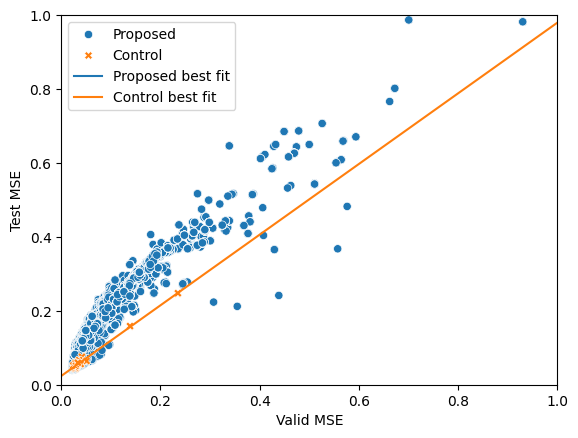

In [226]:
valid_metric = (
    MODEL_SELECTION_CRITERION
    if MODEL_SELECTION_CRITERION.startswith("Valid")
    else "Valid " + MODEL_SELECTION_CRITERION.split(" ")[1]
)
test_metric = (
    "Test " + MODEL_EVALUATION_CRITERION.split(" ")[1]
    if MODEL_EVALUATION_CRITERION.startswith("Valid")
    else MODEL_EVALUATION_CRITERION
)
sns.scatterplot(
    data=results_df, x=valid_metric, y=test_metric, hue="Type", style="Type"
)
plt.xlim(*AXIS_LIM)
plt.ylim(*AXIS_LIM)
# Calculate correlations for each category
correlations = results_df.groupby("Type")[results_df.columns].apply(
    lambda df: df[valid_metric].corr(df[test_metric])
)
print("Correlations between Valid and Test metrics:")
print("Control", correlations.get("Control", np.nan))
print("Proposed", correlations.get("Proposed", np.nan))

# Add best fit lines for each category
for typ in results_df["Type"].unique():
    subset = results_df[results_df["Type"] == typ]
    x = subset[valid_metric]
    y = subset[test_metric]
    m, b = np.polyfit(x, y, 1)
    x_line = np.linspace(*AXIS_LIM, 100)
    plt.plot(x_line, m * x_line + b, label=f"{typ} best fit")
plt.legend()
plt.show()

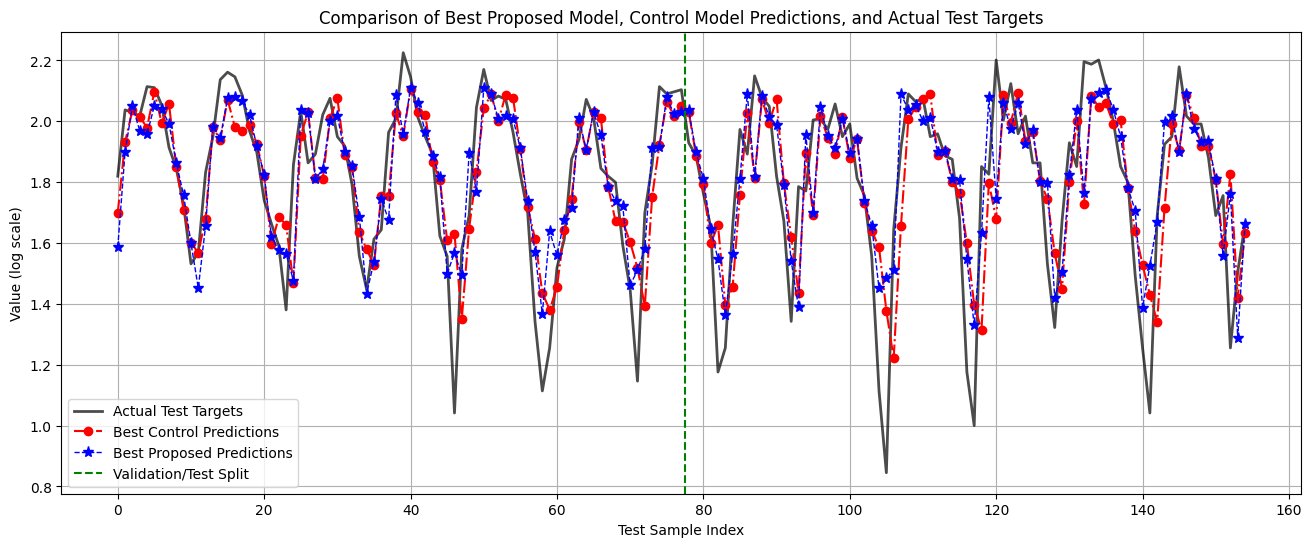

In [227]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][
    MODEL_SELECTION_CRITERION
].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][
    MODEL_SELECTION_CRITERION
].idxmin()
best_proposed_res = proposed_results[best_proposed_idx]

best_control_idx = results_df[results_df["Type"] == "Control"][
    MODEL_SELECTION_CRITERION
].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Control"][
    MODEL_SELECTION_CRITERION
].idxmin()
best_control_res = control_results[best_control_idx - len(proposed_results)]

# Get test targets (actual values for test set)
test_targets = best_proposed_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(16, 6))
plt.plot(test_targets, label="Actual Test Targets", color="black", linewidth=2,  alpha=.7)
plt.plot(
    best_control_res.test_predictions,
    label=f"Best Control Predictions",
    color="red",
    linestyle="-.",
    marker='o',
)
plt.plot(
    best_proposed_res.test_predictions,
    label=f'Best Proposed Predictions',
    color="blue",
    linestyle="--",
    linewidth=1,
    marker='*',
    markersize=8,
)
plt.axvline(x=validation_cutoff + 0.5, color='green', linestyle='--', label='Validation/Test Split')
plt.xlabel("Test Sample Index")
plt.ylabel("Value (log scale)")
plt.title(
    "Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets"
)
plt.legend()
plt.grid(True)
plt.show()

### Effects of individual hyperparameters

In [246]:
# HYPERPARAM = "optimizer._alpha"
# HYPERPARAM = "optimizer._delta"
HYPERPARAM = "ridge"
# HYPERPARAM = "tsvd_alpha"
# HYPERPARAM = "num_components"
# HYPERPARAM = "post_tune"
# HYPERPARAM = "m"
# HYPERPARAM = "approach"
# HYPERPARAM = "optimizer._beta"
# HYPERPARAM = "optimizer._epsilon"
# HYPERPARAM = "use_kmeans_centres"
# HYPERPARAM = "use_local_sigma"

METRIC_LOG_SCALE = True
PARAM_LOG_SCALE = True

PROPOSED_HYPERPARAM = True

OPTIMIZER_SET = set(["SimpleLSOptimizer"])
# OPTIMIZER_SET = None

if OPTIMIZER_SET is not None:
    assert all(opt in list(results_df["Optimizer"].unique()) for opt in OPTIMIZER_SET), f"Some optimizers in results_df are not in the specified OPTIMIZER_SET: {OPTIMIZER_SET} (possible optimizers: {list(results_df['Optimizer'].unique())})"

In [247]:
DIST_PLOT_X_LIM = (0, 10)
# DIST_PLOT_X_LIM = (0.4, 0.45)

In [248]:
hyperparam_values = (
    map(
        lambda cfg: cfg.__dict__.get(HYPERPARAM, None),
        proposed_configs if PROPOSED_HYPERPARAM else control_configs,
    )
    if not HYPERPARAM.startswith("optimizer.")
    else map(
        lambda cfg: cfg.optimizer.__dict__.get(HYPERPARAM.split(".")[1], None),
        proposed_configs if PROPOSED_HYPERPARAM else control_configs,
    )
)

hyperparam_results_df = results_df[
    results_df["Type"] == ("Proposed" if PROPOSED_HYPERPARAM else "Control")
].copy()
hyperparam_results_df[test_metric] = (
    1 - hyperparam_results_df[test_metric]
    if MODEL_EVALUATION_CRITERION_SHOULD_MAXIMIZE
    else hyperparam_results_df[test_metric] - 1
)
hyperparam_results_df[HYPERPARAM] = list(hyperparam_values)

In [249]:
hyperparam_results_df = hyperparam_results_df[
            (hyperparam_results_df[test_metric] <= DIST_PLOT_X_LIM[1]) & (hyperparam_results_df[test_metric] >= DIST_PLOT_X_LIM[0] ) 
        ]
assert not hyperparam_results_df.empty, "No results found within the specified DIST_PLOT_X_LIM."

if OPTIMIZER_SET is not None:
    hyperparam_results_df = hyperparam_results_df[
        hyperparam_results_df["Optimizer"].str.strip().isin(OPTIMIZER_SET)
    ]
    assert not hyperparam_results_df.empty, "No results found with the specified names in the given range."
    
assert hyperparam_results_df[HYPERPARAM].nunique() >= 1, "Hyperparameter has only one unique value; cannot plot."

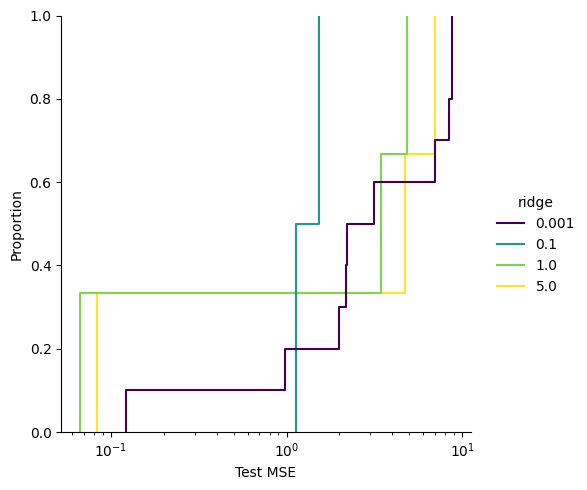

In [250]:
from pandas.api.types import is_numeric_dtype, is_bool_dtype

try:
    sns.displot(
        data=hyperparam_results_df,
        x=test_metric,
        hue=HYPERPARAM,
        hue_norm=(
            LogNorm()
            if PARAM_LOG_SCALE
            and is_numeric_dtype(hyperparam_results_df[HYPERPARAM])
            and not is_bool_dtype(hyperparam_results_df[HYPERPARAM])
            else None
        ),
        kind="ecdf",
        palette="viridis",
        log_scale=(METRIC_LOG_SCALE, False),
    )
except TypeError:
    sns.displot(
        data=hyperparam_results_df,
        x=test_metric,
        hue=HYPERPARAM,
        kind="ecdf",
        palette="viridis",
        log_scale=(METRIC_LOG_SCALE, False),
    )
# plt.xlim(right= np.log10(hyperparam_results_df[test_metric].max() / 10))
plt.show()